In [26]:
#pip install spacy
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from spacy import displacy
import numpy as np
import matplotlib.pyplot as plt
from nltk.util import ngrams 
from sklearn.feature_extraction.text import CountVectorizer


#preproc qusetions (make general to list of words)
def lower_and_lemmatize_all_words(df, df_col):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df_col=[lemmatizer.lemmatize(str(df_col[i]).lower()) for i in range(len(df))]
    return(df_col)
    
def remove_punc(text_col, punc_to_remove = ["?", "!", ",", '"', '.', "/", "(", ")", ";", ":", "-"]):
    for punc in punc_to_remove:
        text_col = text_col.str.replace(punc, " ")
    return(text_col)


def replace_specific_with_common(text_col):
    entity_docs = []
    for doc in text_col:
        new_doc = ""
        for word in doc.split():
            if "$" in word:
                new_doc += "dollar_amt_ "
            elif word.isalpha():
                new_doc += word + " "
            elif word.isnumeric() and len(word) == 4 and word[:2] in ["20", "19"]:
                new_doc += "year_num_ "
            elif word.isnumeric():
                new_doc += "number_ "
            elif any(chr.isdigit() for chr in word) and any(chr.isalpha() for chr in word):
                new_doc += "model_spec_ "
            elif any(chr.isdigit() for chr in word) and ("'" in word or '"' in word):
                new_doc += "model_spec_ "
        #print(new_doc)
        entity_docs.append(new_doc.strip())
    return(entity_docs)

def get_n_most_words(col, n_highest):
    stop_words = stopwords.words('english')
    returned_items = []
    while len(returned_items) < n_highest:
        for item in Counter(" ".join(col).split()).most_common():
            if item[0].strip() not in list(stop_words):
                #print(returned_items)
                returned_items.append(item)
                #print(returned_items)
        if len(returned_items) >= len(Counter(" ".join(col).split()).most_common()):
            break
    returned_items = returned_items[:n_highest]
    return(returned_items)

def get_top_nouns(col):
    top_nouns = []
    words_only = []
    for item in get_n_most_words(col, n_highest = 100):
        words_only.append(item[0])
    for item in nltk.pos_tag(words_only):
        if item[1] == 'NN'  and "_" not in item[0]:
            top_nouns.append(item[0])
    return(top_nouns[:10])

def get_noun_detectors(col):
    all_word_detectors = []
    col_names = []
    for noun in get_top_nouns(col = col):
        word_detector = []
        col_names.append("wd_" + noun)
        for i in range(len(df)):
            if noun in col[i]: 
                word_detector.append(1)
            else:
                word_detector.append(0)
        all_word_detectors.append(word_detector)
    noun_detectors = pd.DataFrame(all_word_detectors).transpose()
    noun_detectors.columns = col_names
    return(noun_detectors)

#look at overall -- 

def get_most_common_words(text_col, n_highest = 10):
    data = get_n_most_words(text_col, n_highest = n_highest)
    ind = np.arange(len(data))  # the x locations for the groups
    names, values = zip(*data)
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, values, width, color='r')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Count')
    ax.set_xticks(ind+width/2.)
    ax.set_xticklabels(names)



    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    plt.xticks(rotation=90)

    plt.show()

# Preprocessing involves doing the following to each of the question and item names --
1) Standardization of all words -- I put all words in lowercase and lemmatized all words so that past tense is treated the same as present tense which is treated the same as future tense

2) Removal of punctuation --- this would allow for us to only consider words which have semantic meaning toward predicting a class, which in this case is 'Post' or 'Pre'

3) I replaced common text patterns with overarching categories -- 
   
    i) I noticed that any token/word with a combo of alphabetic and numeric characters was likely a model number or a specification of a model -- renamed "model_spec_"

    ii) Any four digit numeric string starting with '20' or '19' was considered a year

    iii) Anything with '$' in it was called 'dollar_amt_'
    
    iv) Any numeric token/word was changed to 'number_'

4) Top nouns -- used for determining variations in tokens later. Since ultimately the item names refer to a tool, which is a noun, I decided to ultimately look at word counts (and coded bigram counts) and how they differ across 'Pre' and 'Post' for all questions referring to an item that had that 'common noun'. Stop words were excluded and assumed to have no predictive capacity. 

5) 'hours_diff' was also normalized - many of these numbers were much larger in magnitude than those that will be used for modeling purposes (i.e. tf-idf of words/bigrams or binary for if a common noun is present in an item) and therefore we do not want the 'hours_diff' to "overpower" the other variables whose magnitudes are on a much smaller scale. 

Approach: 
Ultimately, the primary goal through my approach of EDA is to look for if the discrepancies for single words/tokens and n-grams (bigrams) across 'Pre' and 'Post' and a step further by common noun

These differences in words or n-grams will ultimately be indicative of how suuccessful a model will be based on different NLP classification -- whether it is a naive bayes models based on the tf-idf of questions' words in a Naive Bayes model, a RNN with the ability to look at sequential text patterns, or others.

In [ ]:
df = pd.read_csv('PrePostQuestions.csv')

#preproc questions
df['question'] = lower_and_lemmatize_all_words(df = df, df_col = df['question'])
df['question'] = remove_punc(text_col = df['question'])
df['question'] = replace_specific_with_common(df['question'])

#preproc item names
df['item_name'] = lower_and_lemmatize_all_words(df = df, df_col = df['item_name'])
df['item_name'] = remove_punc(text_col = df['item_name'])
df['item_name'] = replace_specific_with_common(df['item_name'])
noun_detectors_df = get_noun_detectors(col = df.item_name)
full_df = pd.concat([df, noun_detectors_df], axis = 1)
full_df['hours_diff'] = (full_df['hours_diff'] - min(full_df['hours_diff']))/(max(full_df['hours_diff']) - min(full_df['hours_diff']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


# Top word counts for 'Pre' as opposed to 'Post' questions
Compare to overall graph after

Pre


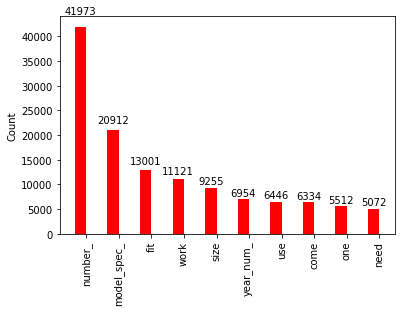

Post


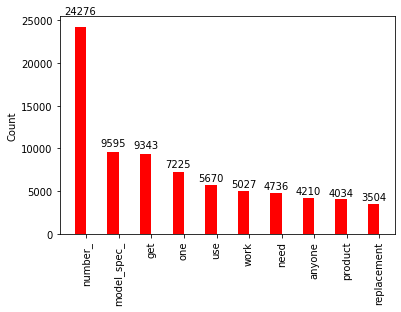

In [28]:
###look at most common words pre vs post
print("Pre")
get_most_common_words(text_col = full_df[full_df.label == 'Pre'].reset_index(drop = True)['question'], n_highest = 10)

print("Post")
get_most_common_words(text_col = full_df[full_df.label == 'Post'].reset_index(drop = True)['question'], n_highest = 10)



# Overall: top word counts for ALL questions

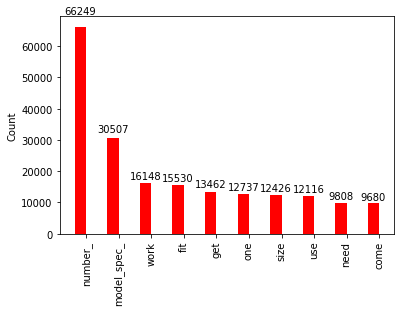

In [29]:

get_most_common_words(text_col= full_df.question, n_highest = 10)



# Most common words -- By Top 10 Most Common Nouns 
Out of all rows whose 'item_name' contains a common noun, what are the most common words for 'Pre' and 'Post' questions? The intent here was to see if there was enough variation in 'Pre' questions and 'Post Questions' across the different nouns and make them dummy variables

wd_pack
Pre


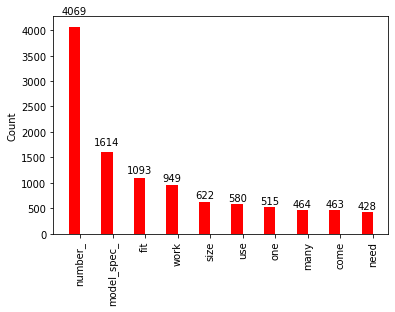

Post


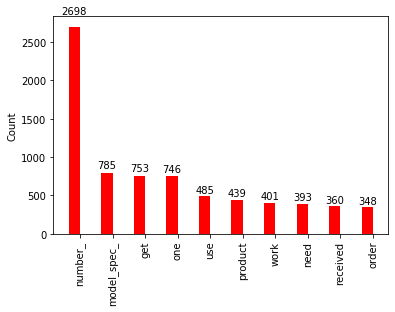

wd_inch
Pre


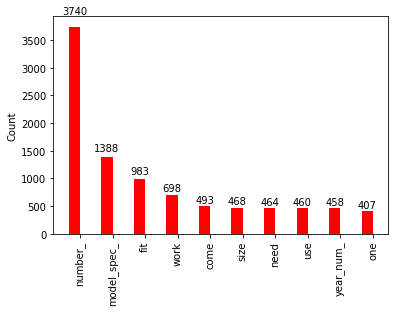

Post


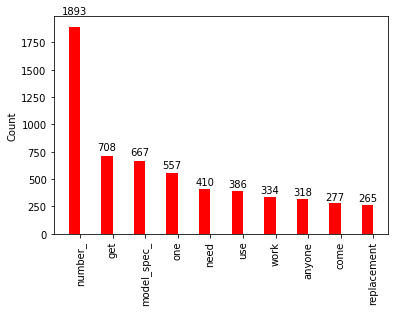

wd_wireless
Pre


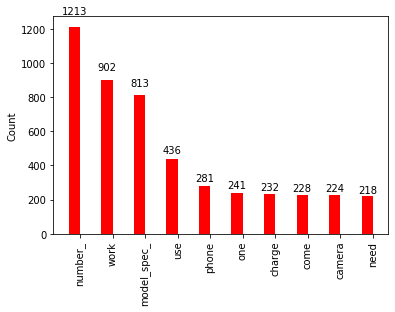

Post


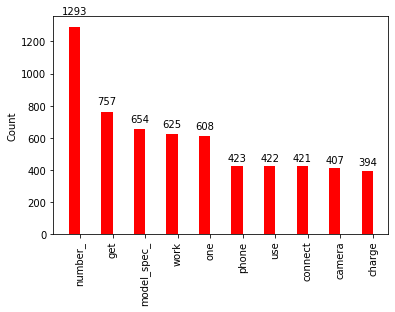

wd_camera
Pre


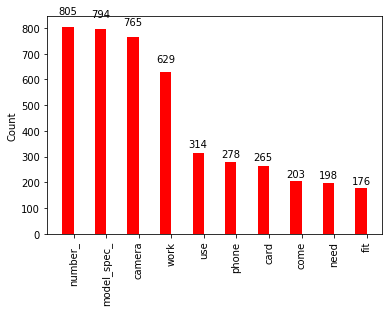

Post


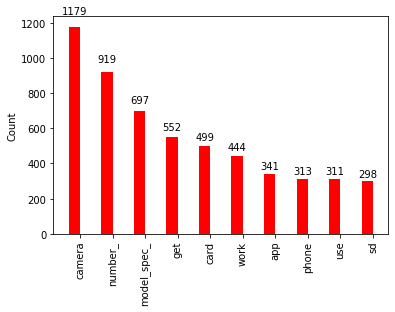

wd_home
Pre


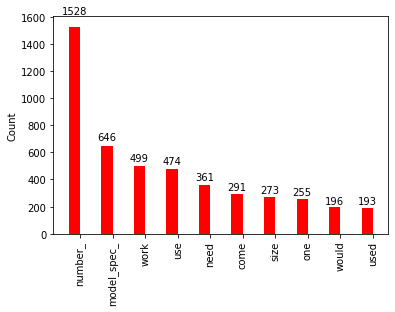

Post


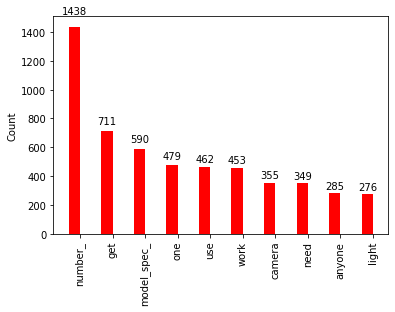

wd_kit
Pre


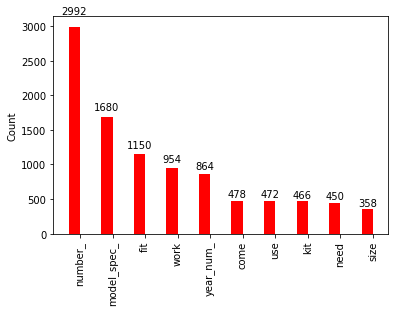

Post


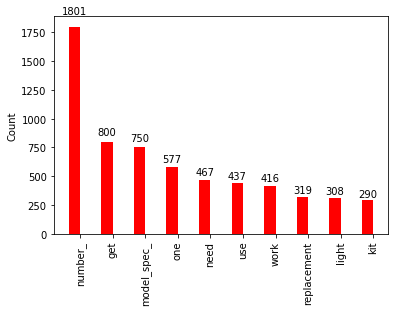

wd_case
Pre


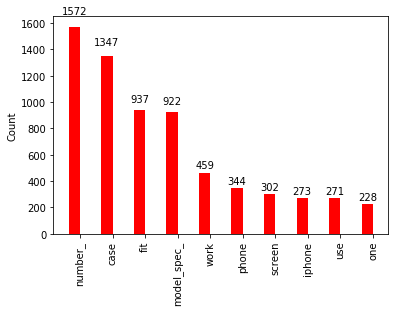

Post


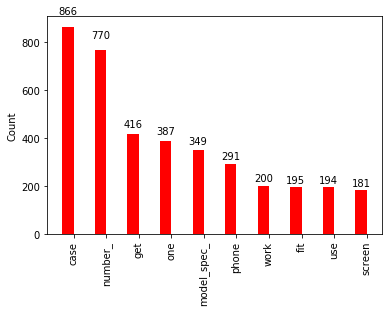

wd_car
Pre


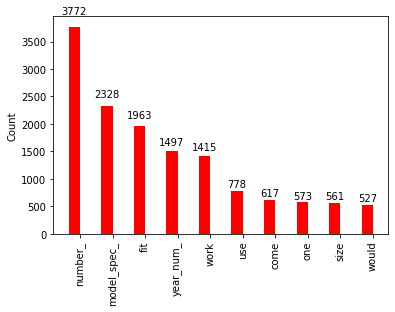

Post


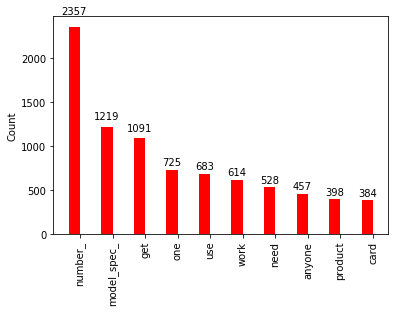

wd_waterproof
Pre


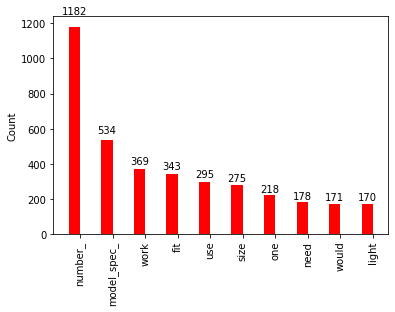

Post


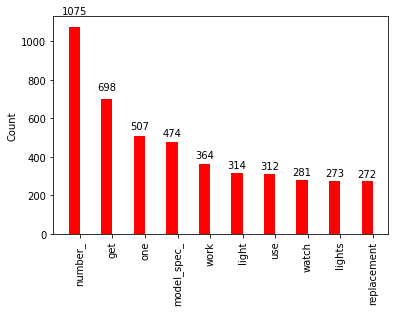

wd_battery
Pre


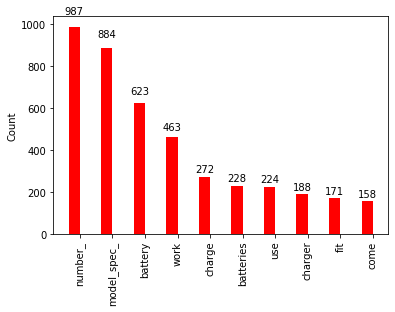

Post


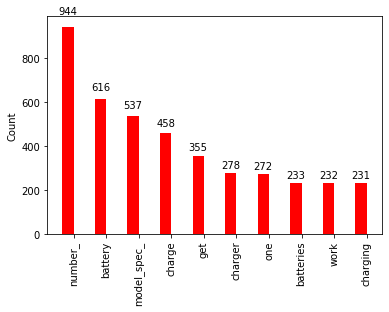

In [30]:
# make function to print out most popular wordsd across most common nouns in the item section
for col in full_df.columns:
    if 'wd_' in col:
        wd_df = full_df[full_df[col] == 1].reset_index(drop = True)
        print(col)
        print("Pre")
        get_most_common_words(text_col= wd_df[wd_df.label == 'Pre'].reset_index(drop = True).question, n_highest = 10)
        print("Post")
        get_most_common_words(text_col= wd_df[wd_df.label == 'Post'].reset_index(drop = True).question, n_highest = 10)

# What are the 10 most common bigrams for 'Pre' questions and most common bigrams for 'Post' questions?

In [ ]:
###Look at bigrams pre and post overall, then get by common nouns -- would complete if had access to Cloud Computing notebook

##overall
top_n = 10
word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(full_df['question'])
frequencies = sum(sparse_matrix).toarray()[0]
n_gram_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['question']).sort_values('question', ascending = False)
print("Overall")
print(n_gram_freq[:top_n])


####Pre
sparse_matrix = word_vectorizer.fit_transform(full_df[full_df.label == 'Post'].reset_index(drop =True)['question'])
frequencies = sum(sparse_matrix).toarray()[0]
n_gram_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['question']).sort_values('question', ascending = False)
print("Pre")
print(n_gram_freq[:top_n])

####Post
sparse_matrix = word_vectorizer.fit_transform(full_df[full_df.label == 'Post'].reset_index(drop =True)['question'])
frequencies = sum(sparse_matrix).toarray()[0]
n_gram_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['question']).sort_values('question', ascending = False)
print("Post")
print(n_gram_freq[:top_n])


# What are the 10 most common bigrams for 'Pre' questions and most common bigrams for 'Post' questions by common noun?

In [8]:
###Look at bigrams pre and post by common nouns -- would complete if had access to Cloud Computing notebook

top_n = 10

for col in full_df.columns:
    word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')

    if 'wd_' in col:
        wd_df = full_df[full_df[col] == 1].reset_index(drop = True)
        print(col)
        print("Pre")
        sparse_matrix = word_vectorizer.fit_transform(wd_df[wd_df.label == 'Pre'].reset_index(drop = True).question)
        frequencies = sum(sparse_matrix).toarray()[0]
        n_gram_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['question']).sort_values('question', ascending = False)
        print(n_gram_freq[:top_n])

        print("Post")
        
        sparse_matrix = word_vectorizer.fit_transform(wd_df[wd_df.label == 'Post'].reset_index(drop = True).question)
        frequencies = sum(sparse_matrix).toarray()[0]
        n_gram_freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['question']).sort_values('question', ascending = False)
        print(n_gram_freq[:top_n])

wd_pack
Pre


KeyboardInterrupt: 

0.0